# Set-up

In [1]:
import os
import sys
import torch
import numpy as np
import seqdata as sd
from eugene import models
from eugene.models import zoo
import seqexplainer as se
from eugene import plot as pl
import matplotlib.pyplot as plt

sys.path.append("/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind/bin")
from plot import scatter

In [2]:
# Change current working directory to the directory of this script
cwd = "/cellar/users/aklie/projects/ML4GLand/use_cases/ResidualBind"
os.chdir(cwd)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Using device: cuda


# Load test dataset

In [4]:
# Load the dataset
sdata = sd.open_zarr("/cellar/users/aklie/data/ml4gland/pubs/koo21_gia/log_norm/rnacompete2013_test.zarr")
sdata.load()

<xarray.Dataset>
Dimensions:    (_sequence: 121031, _length: 41, _ohe: 4, _target: 244)
Dimensions without coordinates: _sequence, _length, _ohe, _target
Data variables:
    inputs     (_sequence, _length, _ohe) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rbp_id     (_target) <U11 'RNCMPT00100' 'RNCMPT00101' ... 'RNCMPT00009'
    rbp_index  (_target) int64 0 1 2 3 4 5 6 7 ... 237 238 239 240 241 242 243
    targets    (_sequence, _target) float32 0.795 -0.2654 -0.2193 ... 0.6552 nan

# Load best model

In [5]:
# Instantiate an architecture
arch = zoo.ResidualBind(
    input_len=41,
    output_dim=1
)

In [27]:
module = models.SequenceModule.load_from_checkpoint(
    "models/2023_12_16/ResidualBind/log_norm/RNCMPT00100/best_model.ckpt",
    arch=arch,
)

[rank: 0] Global seed set to 1234


# Get predictions

In [28]:
module.to(device).eval();

In [29]:
preds = module.predict(
    sdata["inputs"].values.transpose(0, 2, 1),
    batch_size=128
).cpu().numpy().squeeze()

Predicting on batches:   0%|          | 0/945 [00:00<?, ?it/s]

In [30]:
sdata["target"] = sdata["targets"][:, 0]
obs = sdata["target"].values

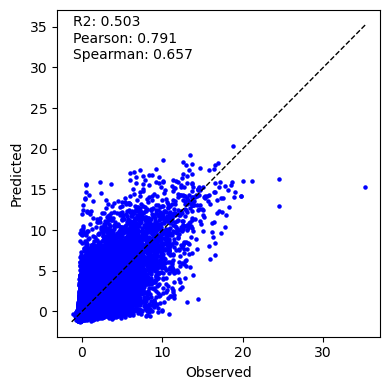

In [31]:
scatter(
    preds,
    obs,
    density=False,
    rasterized=True,
    s=5,
)

# Interpret

In [174]:
from seqexplainer.attributions._references import (
    zero_ref_inputs, 
    random_ref_inputs,
    k_shuffle_ref_inputs,
    gc_ref_inputs,
    profile_ref_inputs,
)

In [175]:
inputs = sdata["inputs"][:128].values.transpose(0, 2, 1)

In [176]:
zero_outputs = module.predict(zero_ref_inputs(inputs))
np.unique(zero_outputs.cpu().numpy(), return_counts=True)

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

(array([-0.38939482], dtype=float32), array([128]))

In [177]:
def random_ref_inputs(inputs):
    N, A, L = inputs.shape
    ref_tokens = np.random.randint(4, size=(N, L))
    refs = np.eye(A)[ref_tokens].transpose(0, 2, 1)
    return refs

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

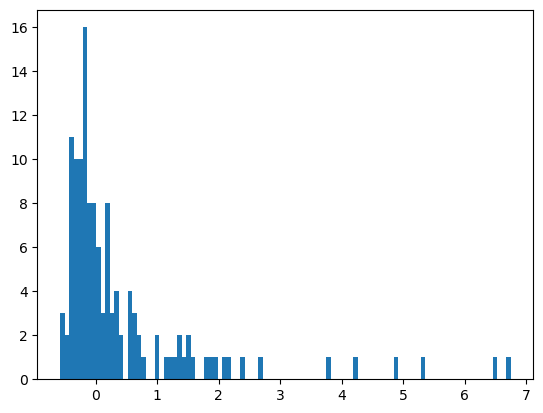

In [178]:
random_outputs = module.predict(random_ref_inputs(inputs))
plt.hist(random_outputs.cpu().numpy(), bins=100);

In [181]:
import seqpro as sp


def k_shuffle_ref_inputs(inputs, k=2):
    input_seqs = sp.decode_ohe(inputs.astype(np.uint8), alphabet=sp.alphabets.RNA, ohe_axis=1)
    ref_seqs = sp.k_shuffle(input_seqs, k=k, length_axis=1)
    refs = sp.ohe(ref_seqs, alphabet=sp.alphabets.RNA).transpose(0, 2, 1)
    return refs

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

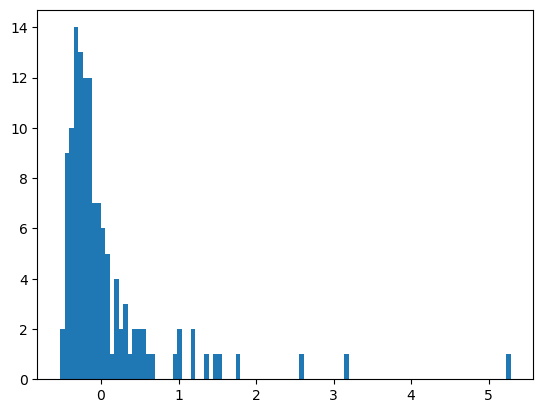

In [182]:
shuffled_outputs = module.predict(k_shuffle_ref_inputs(inputs, k=1))
plt.hist(shuffled_outputs.cpu().numpy(), bins=100);

In [202]:
def gc_ref_inputs(
    inputs,
    bg="uniform",
    uniform_dist=[0.25, 0.25, 0.25, 0.25],
):
    N, A, L = inputs.shape
    if bg == "uniform":
        dists = np.array(uniform_dist)[:, None]
        dists = np.broadcast_to(dists, (A, L))
        refs = np.broadcast_to(dists[None, :, :], (N, A, L))
    elif bg == "batch":
        dists = inputs.sum(0)/N
        dists = dists[None, :]
        refs = np.broadcast_to(dists, (N, A, L))
    elif bg == "seq":
        dists = inputs.sum(2)/L
        refs = np.tile(dists[:, :, np.newaxis], (1, 1, L)) 
    else:
        raise ValueError(f"Background distribution {bg} not in ['uniform', 'batch', 'seq']")
    return refs 

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

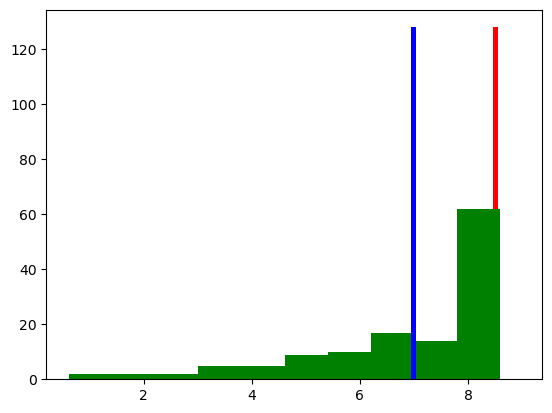

In [217]:
gc_outputs = module.predict(gc_ref_inputs(inputs, bg="uniform"))
plt.hist(gc_outputs.cpu().numpy(), bins=10, color="red")

gc_outputs = module.predict(gc_ref_inputs(inputs, bg="seq"))
plt.hist(gc_outputs.cpu().numpy(), bins=10, color="green");

gc_outputs = module.predict(gc_ref_inputs(inputs, bg="batch"))
plt.hist(gc_outputs.cpu().numpy(), bins=10, color="blue");

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

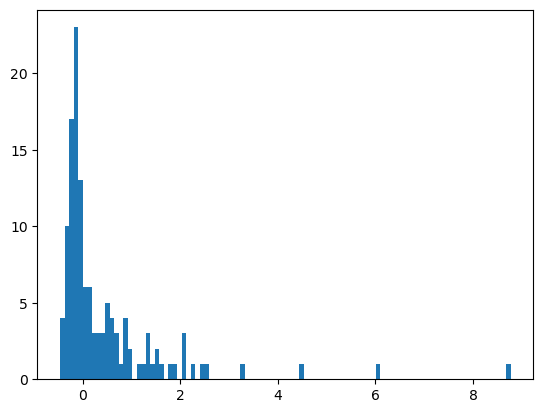

In [218]:
profile_outputs = module.predict(profile_ref_inputs(inputs))
plt.hist(profile_outputs.cpu().numpy(), bins=100);

In [273]:
from captum.attr import DeepLift, DeepLiftShap, GradientShap, InputXGradient, IntegratedGradients
from seqexplainer._ism import _naive_ism
from seqexplainer.attributions._plot import plot_attribution_logo

def negative_average(ism_attr, inputs):
    avgs = ism_attr.mean(1) * -1
    avgs = avgs.reshape(avgs.shape[0], -1, avgs.shape[-1])
    avgs = np.repeat(avgs, 4, axis=1)
    ism_attr = inputs * avgs
    return ism_attr

In [455]:
ism_attr = _naive_ism(module, torch.tensor(inputs, dtype=torch.float32)).numpy()

In [453]:
ism_attr -= np.mean(ism_attr, axis=1, keepdims=True)
ism_attr = ism_attr*inputs

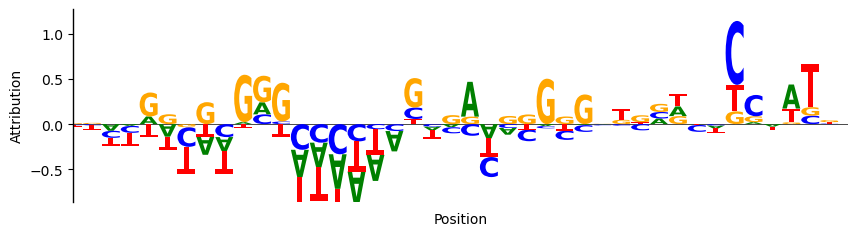

In [456]:
#ism_attr = _naive_ism(module, torch.tensor(inputs, dtype=torch.float32)).numpy()
#ism_attr = negative_average(ism_attr, inputs)
plot_attribution_logo(ism_attr[3])

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


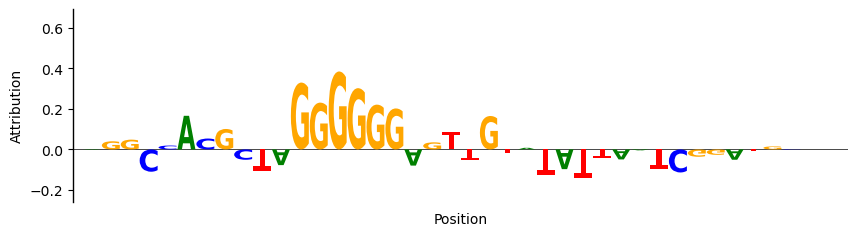

In [285]:
atrributor = InputXGradient(module)
ixg_attr = atrributor.attribute(torch.tensor(inputs, dtype=torch.float32)).detach().numpy()
plot_attribution_logo(ixg_attr[3])

In [481]:
def custom_attribution_func(multipliers, inputs, baselines):
    out = multipliers[0] * (inputs[0] - baselines[0])
    out = out.sum(1)
    out = out.reshape(out.shape[0], -1, out.shape[-1])
    out = torch.repeat_interleave(out, 4, dim=1)
    out = inputs[0] * out
    return (out,)

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


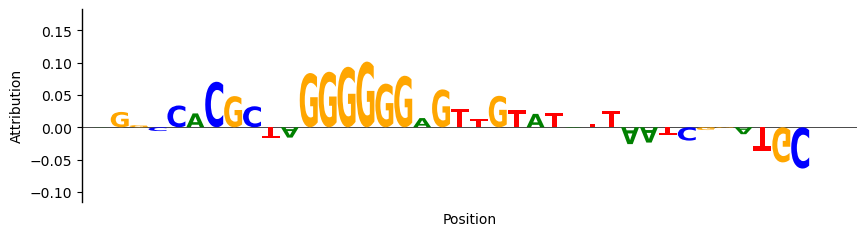

In [484]:
attributor = DeepLift(module, multiply_by_inputs=True)
dl_attr, delta = attributor.attribute(
    inputs=torch.tensor(inputs, dtype=torch.float32),
    baselines=torch.tensor(zero_ref_inputs(inputs), dtype=torch.float32),
    #baselines=torch.tensor(k_shuffle_ref_inputs(inputs, k=2), dtype=torch.float32),
    return_convergence_delta=True,
    custom_attribution_func=hypothetical_attributions,
    #custom_attribution_func=custom_attribution_func,
)
dl_attr = dl_attr.detach().numpy()*inputs
plot_attribution_logo(dl_attr[3])

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


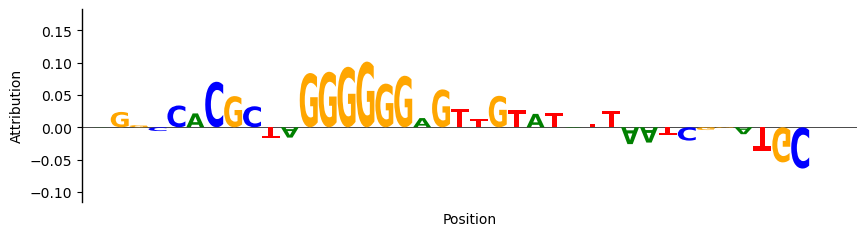

In [485]:
attributor = DeepLift(module, multiply_by_inputs=True)
dl_attr, delta = attributor.attribute(
    inputs=torch.tensor(inputs, dtype=torch.float32),
    baselines=torch.tensor(zero_ref_inputs(inputs), dtype=torch.float32),
    #baselines=torch.tensor(k_shuffle_ref_inputs(inputs, k=2), dtype=torch.float32),
    return_convergence_delta=True,
    #custom_attribution_func=hypothetical_attributions,
    custom_attribution_func=custom_attribution_func,
)
dl_attr = dl_attr.detach().numpy()*inputs
plot_attribution_logo(dl_attr[3])

In [366]:
def average(attr, inputs):
    avgs = attr.mean(1)
    avgs = avgs.reshape(avgs.shape[0], -1, avgs.shape[-1])
    avgs = np.repeat(avgs, 4, axis=1)
    attr = inputs * avgs
    return attr

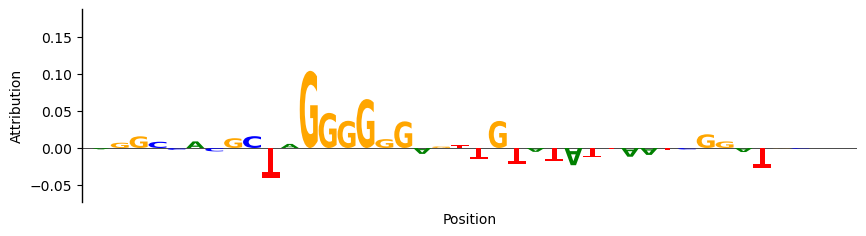

In [370]:
attributor = GradientShap(module, multiply_by_inputs=True)
gs_attr, delta = attributor.attribute(
    inputs=torch.tensor(inputs, dtype=torch.float32),
    baselines=torch.tensor(k_shuffle_ref_inputs(inputs, k=2), dtype=torch.float32),
    return_convergence_delta=True,
)
gs_attr = average(gs_attr.detach().numpy(), inputs)
plot_attribution_logo(gs_attr[3])

In [398]:
from bpnetlite.attributions import DeepLiftShap, hypothetical_attributions, create_references

In [497]:
refs = create_references(torch.tensor(inputs, dtype=torch.float32))

In [502]:
attributor = DeepLiftShap(
    model=module,
    attribution_func=hypothetical_attributions,
    warning_threshold=0.001,
    verbose=True
)

tensor([0.0000e+00, 0.0000e+00, 5.9605e-08,  ..., 0.0000e+00, 0.0000e+00,
        2.0862e-07], grad_fn=<AbsBackward0>)


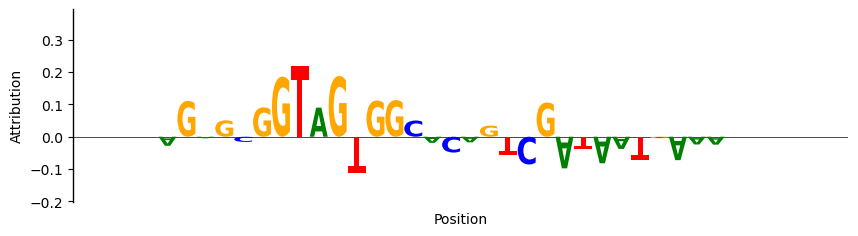

In [504]:
dls_attrs = attributor.attribute(
    inputs=torch.tensor(inputs, dtype=torch.float32),
    baselines=refs,
    target=None
).detach().numpy()
dls_attrs = dls_attrs*inputs
plot_attribution_logo(dls_attrs[20])

In [409]:
def random_ref_inputs(
    inputs,
    n_per_input=1,
):
    N, A, L = inputs.shape
    if n_per_input == 1:
        ref_tokens = np.random.randint(4, size=(N, L))
        refs = np.eye(A)[ref_tokens].transpose(0, 2, 1)
    else:
        ref_tokens = np.random.randint(4, size=(N, n_per_input, L))
        refs = np.eye(A)[ref_tokens].transpose(0, 1, 3, 2)
    return refs

In [417]:
import seqpro as sp


def k_shuffle_ref_inputs(inputs, k=2, n_per_input=1):
    if n_per_input == 1:
        input_seqs = sp.decode_ohe(inputs.astype(np.uint8), alphabet=sp.alphabets.RNA, ohe_axis=1)
        ref_seqs = sp.k_shuffle(input_seqs, k=k, length_axis=1)
        refs = sp.ohe(ref_seqs, alphabet=sp.alphabets.RNA).transpose(0, 2, 1)
    else:
        refs = np.zeros((inputs.shape[0], n_per_input, inputs.shape[1], inputs.shape[2]))
        for i in range(n_per_input):
            input_seqs = sp.decode_ohe(inputs.astype(np.uint8), alphabet=sp.alphabets.RNA, ohe_axis=1)
            ref_seqs = sp.k_shuffle(input_seqs, k=k, length_axis=1)
            refs[:, i, :, :] = sp.ohe(ref_seqs, alphabet=sp.alphabets.RNA).transpose(0, 2, 1)
    return refs

In [440]:
#refs = random_ref_inputs(inputs, n_per_input=20)
refs = k_shuffle_ref_inputs(inputs, k=2, n_per_input=20)
refs.shape

(128, 20, 4, 41)

tensor([2.3842e-07, 0.0000e+00, 4.7684e-07,  ..., 7.1526e-07, 0.0000e+00,
        2.3842e-07], grad_fn=<AbsBackward0>)


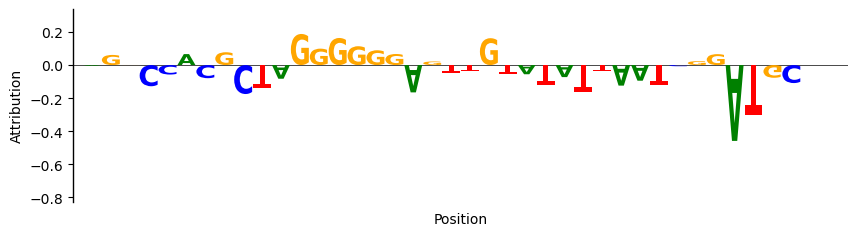

In [441]:
dls_attrs = attributor.attribute(
    inputs=torch.tensor(inputs, dtype=torch.float32),
    baselines=torch.tensor(refs, dtype=torch.float32)
).detach().numpy()
dls_attrs = dls_attrs*inputs
plot_attribution_logo(dls_attrs[3])

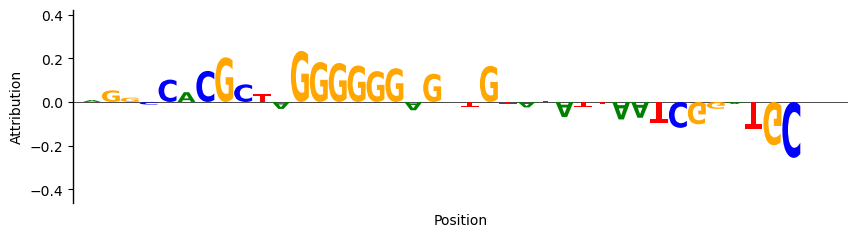

In [444]:
attributor = IntegratedGradients(module)
ig = attributor.attribute(
    inputs=torch.tensor(inputs, dtype=torch.float32),
    baselines=torch.tensor(zero_ref_inputs(inputs), dtype=torch.float32),
    target=0,
).detach().numpy()
plot_attribution_logo(ig[3])

In [244]:
index = [29849, 105952]
X = sdata['inputs'].values[index]

In [77]:

def mutagenesis(model, X):

    def generate_mutagenesis(X):
        L,A = X.shape 

        X_mut = []
        for l in range(L):
            for a in range(A):
                X_new = np.copy(X)
                X_new[l,:] = 0
                X_new[l,a] = 1
                X_mut.append(X_new)
        return np.array(X_mut)

    N, L, A = X.shape 

    attr_score = []
    for x in X:

        # get baseline wildtype score
        wt_score = model.predict(np.expand_dims(x, axis=0)).numpy().squeeze()

        # generate mutagenized sequences
        x = x.transpose(1, 0)
        x_mut = generate_mutagenesis(x)
        
        # get predictions of mutagenized sequences
        predictions = model.predict(x_mut.transpose(0,2,1)).numpy().squeeze()
        
        # reshape mutagenesis predictiosn
        mut_score = np.zeros((L,A))
        k = 0
        for l in range(L):
            for a in range(A):
                mut_score[l,a] = predictions[k]
                k += 1
                
        attr_score.append(mut_score - wt_score)
    return np.array(attr_score)

In [78]:
X.shape

(2, 41, 4)

In [86]:
attr_map = mutagenesis(module, X.transpose(0, 2, 1))
scores = (np.sum(attr_map**2, axis=2, keepdims=True)*X.transpose(0, 2, 1)).transpose(0, 2, 1)

Predicting on batches: 0it [00:00, ?it/s]

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting on batches: 0it [00:00, ?it/s]

Predicting on batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [87]:
import pandas as pd
import logomaker as lmddd

In [88]:
scores.shape

(2, 41, 4)

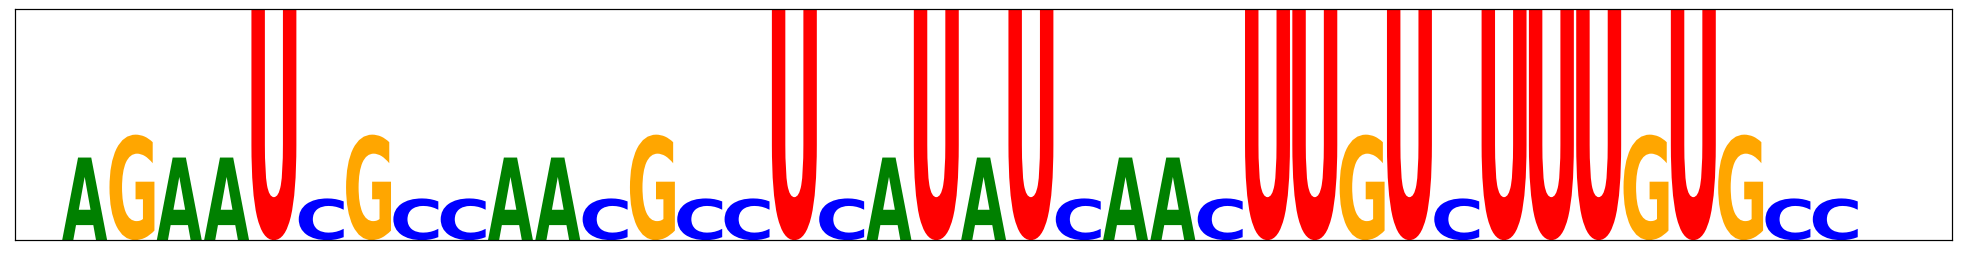

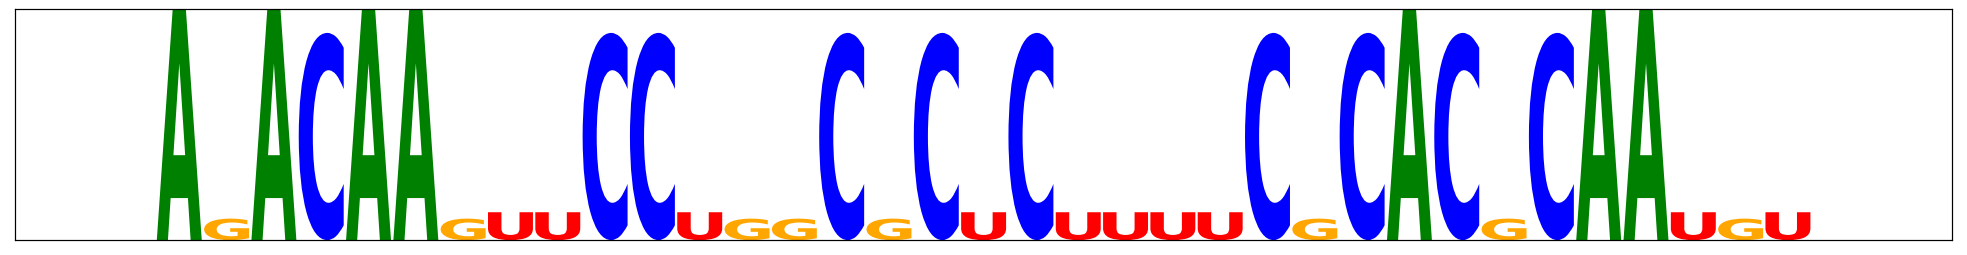

In [89]:
N, L, A = X.shape
for k in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = scores[k,l,a]

    fig = plt.figure(figsize=(25,3))
    ax = plt.subplot(1,1,1)
    lm.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    ax2 = ax.twinx()
    plt.yticks([])
    